## How to make model of Envi Apples by using Gradient Boosting Regression Algorithm
> create dataset that predict the next time step using the previous observation

In [41]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### ***Prepare DataSet of Envi For Modeling***

- ทำการอ่านไฟล์ชุดข้อมูลตัวอย่างของ Envi

In [42]:
df_envi_inter = pd.read_csv("../../../DataSet/Envi/envi.csv")

df_envi_inter

,Date,Envi
0,04/01/2015,44562
1,11/01/2015,38112
2,18/01/2015,50355
3,25/01/2015,51922
4,01/02/2015,67496
...,...,...
164,25/02/2018,42116
165,04/03/2018,44454
166,11/03/2018,28399
167,18/03/2018,49145


In [43]:
df_envi_inter["Date"] = pd.to_datetime(df_envi_inter["Date"],format="%d/%m/%Y")

- ทำนายวันถ้ดไปโดยใส่ค่าปริมาณของแอปเปิ้ลวันก่อนหน้า 1 วัน

In [44]:
df_envi_inter["y"] = df_envi_inter["Envi"].shift(-1)
df_envi_inter.dropna(inplace=True)
df_envi_inter

,Date,Envi,y
0,2015-01-04,44562,38112.0
1,2015-01-11,38112,50355.0
2,2015-01-18,50355,51922.0
3,2015-01-25,51922,67496.0
4,2015-02-01,67496,54229.0
...,...,...,...
163,2018-02-18,39773,42116.0
164,2018-02-25,42116,44454.0
165,2018-03-04,44454,28399.0
166,2018-03-11,28399,49145.0


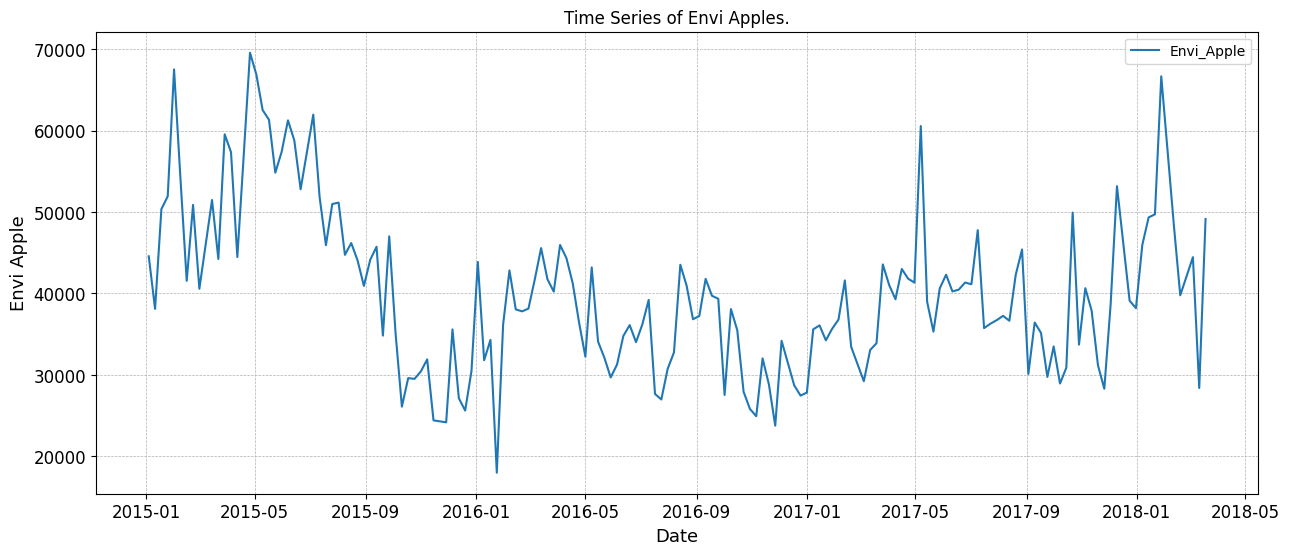

In [45]:
plt.figure(figsize=(15,6))
plt.plot(df_envi_inter['Date'],df_envi_inter["Envi"], label='Envi_Apple')
plt.xlabel("Date", fontsize=13)
plt.ylabel("Number of Envi Apples", fontsize=13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel("Envi Apple")
plt.legend()
plt.title("Time Series of Envi Apples.")
plt.grid(linestyle='--', linewidth='0.5')
plt.show()

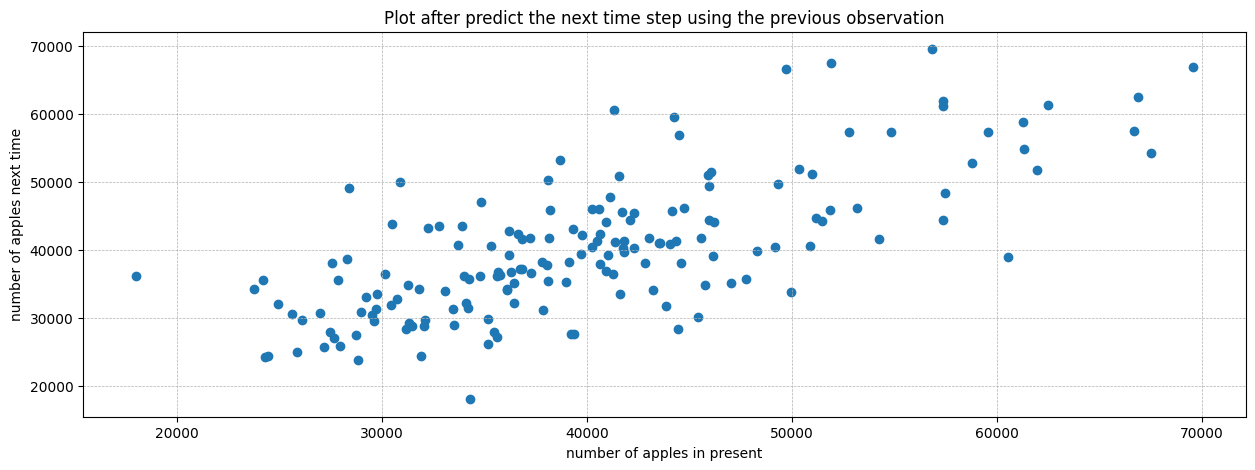

In [46]:
plt.figure(figsize=(15,5))
plt.scatter(df_envi_inter["Envi"], df_envi_inter["y"])
plt.xlabel("number of apples in present")
plt.ylabel("number of apples next time")
plt.title("Plot after predict the next time step using the previous observation")
plt.grid(linestyle='--', linewidth='0.5')
plt.show()

In [47]:
def writeEvaluate(model, mae:np.float64, mse:np.float64, r2:np.float64, mape:np.float64, filename):
    df = pd.read_csv(filename)
    row_index = df.index.get_loc(df.loc[df['Model'] == model].index[0])
    df.at[row_index,'Mae'] = mae
    df.at[row_index,'Mse'] = mse
    df.at[row_index,'R2'] = r2
    df.at[row_index,'Mape'] = mape

    df.to_csv(filename,encoding='utf-8', sep=',', index=False)

- แยกชุดข้อมูลตัวอย่างเป็นชุดข้อมูลตัวอย่างของ training และ test

In [48]:
def findBestRandomState(r,t, x, y):
    random = 0
    a = 100

    model = RegressorChain(GradientBoostingRegressor())
    for _ in range(r,t):
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=_)
        model.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))

        y_predict = model.predict(x_test.reshape(-1, 1))
        if (buff := mean_absolute_error(y_test, y_predict)) < a:
            a = buff
            random = _
    print(a, random)

x = np.array(df_envi_inter.drop(columns='y'))
y = np.array(df_envi_inter.drop(columns='Envi'))

# scaler = StandardScaler()
# scaler.fit(x)
# x = scaler.transform(x.reshape(-1, 1))

# scaler.fit(y)
# y = scaler.transform(y.reshape(-1, 1))



# findBestRandomState(200000,300000,x,y)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=157086)

x_train = np.array(sorted(x_train, key=lambda x: x[0]))
x_test = np.array(sorted(x_test, key=lambda x: x[0]))
y_train = np.array(sorted(y_train, key=lambda x: x[0]))
y_test = np.array(sorted(y_test, key=lambda x: x[0]))

# seed 157086 MAE: 0.3345
# seed 157086 learningRate 0.049 MAE: 0.31832

### ***Train Model Of Envi Apple***

In [49]:
ml = RegressorChain(GradientBoostingRegressor(learning_rate=0.056, max_depth=11, max_leaf_nodes=6))
ml.fit(x_train[:, 1:], y_train[:, 1:])

RegressorChain(base_estimator=GradientBoostingRegressor(learning_rate=0.056,
                                                        max_depth=11,
                                                        max_leaf_nodes=6))

### ***Predict from test_dataset of Envi Apple***

Mean Absolute Error: 3117.4822052501445
Mean Square Error: 16993588.47973846
R2 score: 0.7710993498587391
Mean Absolute Percentage Error: 0.0792240139891161


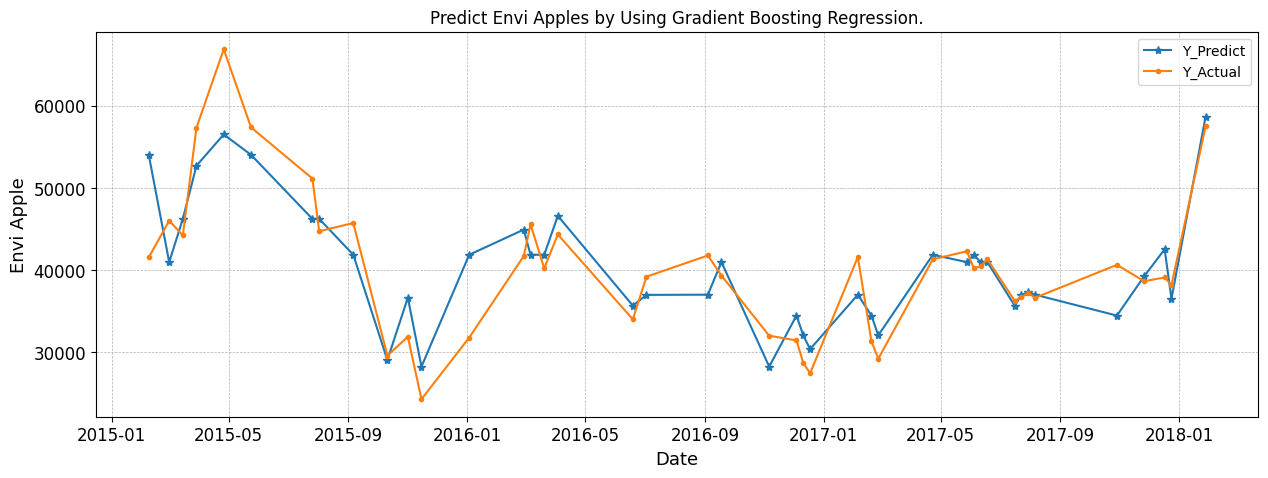

In [50]:
y_predict = ml.predict(x_test[:, 1:])

mae = mean_absolute_error(y_test[:, 1:], y_predict)
mse = mean_squared_error(y_test[:, 1:], y_predict)
r2 = r2_score(y_test[:, 1:], y_predict)
mape = mean_absolute_percentage_error(y_test[:, 1:], y_predict)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Square Error: {mse}")
print(f"R2 score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}")

writeEvaluate("GradientBoosting", mae, mse, r2, mape, "evaluate.csv")

plt.figure(figsize=(15,5))
plt.plot(x_test[:, :1], y_predict, label="Y_Predict", marker='*')
plt.plot(x_test[:,:1], y_test[:, 1:], label="Y_Actual", marker='.')

plt.xlabel("Date", fontsize=13)
plt.ylabel("Number of Envi Apples", fontsize=13)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel("Envi Apple")
plt.legend()
plt.title("Predict Envi Apples by Using Gradient Boosting Regression.")
plt.grid(linestyle='--', linewidth='0.5')
plt.show()